<a href="https://colab.research.google.com/github/Vedant285/Credit-Card-Fraud-Detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Importing Necessary Libraries

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. The Data Set

In [4]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('/content/creditcard.csv')

In [5]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
# Print the shape of the data
data = data.sample(frac=0.1, random_state = 1)
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(1792, 31)
               Time           V1           V2           V3           V4  \
count   1792.000000  1792.000000  1792.000000  1792.000000  1792.000000   
mean   14236.513393    -0.270126     0.242554     0.833711     0.296708   
std     9872.002349     1.995215     1.464953     1.808703     1.495217   
min        2.000000   -30.552380   -15.732974   -31.103685    -3.702028   
25%     4111.500000    -0.979354    -0.305670     0.409130    -0.680486   
50%    13120.000000    -0.312150     0.218721     0.954781     0.221089   
75%    24436.750000     1.162510     0.857898     1.581637     1.203959   
max    29025.000000     1.597947    16.713389     3.940337     6.534984   

                V5           V6           V7           V8           V9  ...  \
count  1792.000000  1792.000000  1792.000000  1792.000000  1792.000000  ...   
mean     -0.174489     0.076511    -0.143287     0.026252     0.713186  ...   
std       1.409779     1.272627     1.291105     1.284080     1.283304  ... 

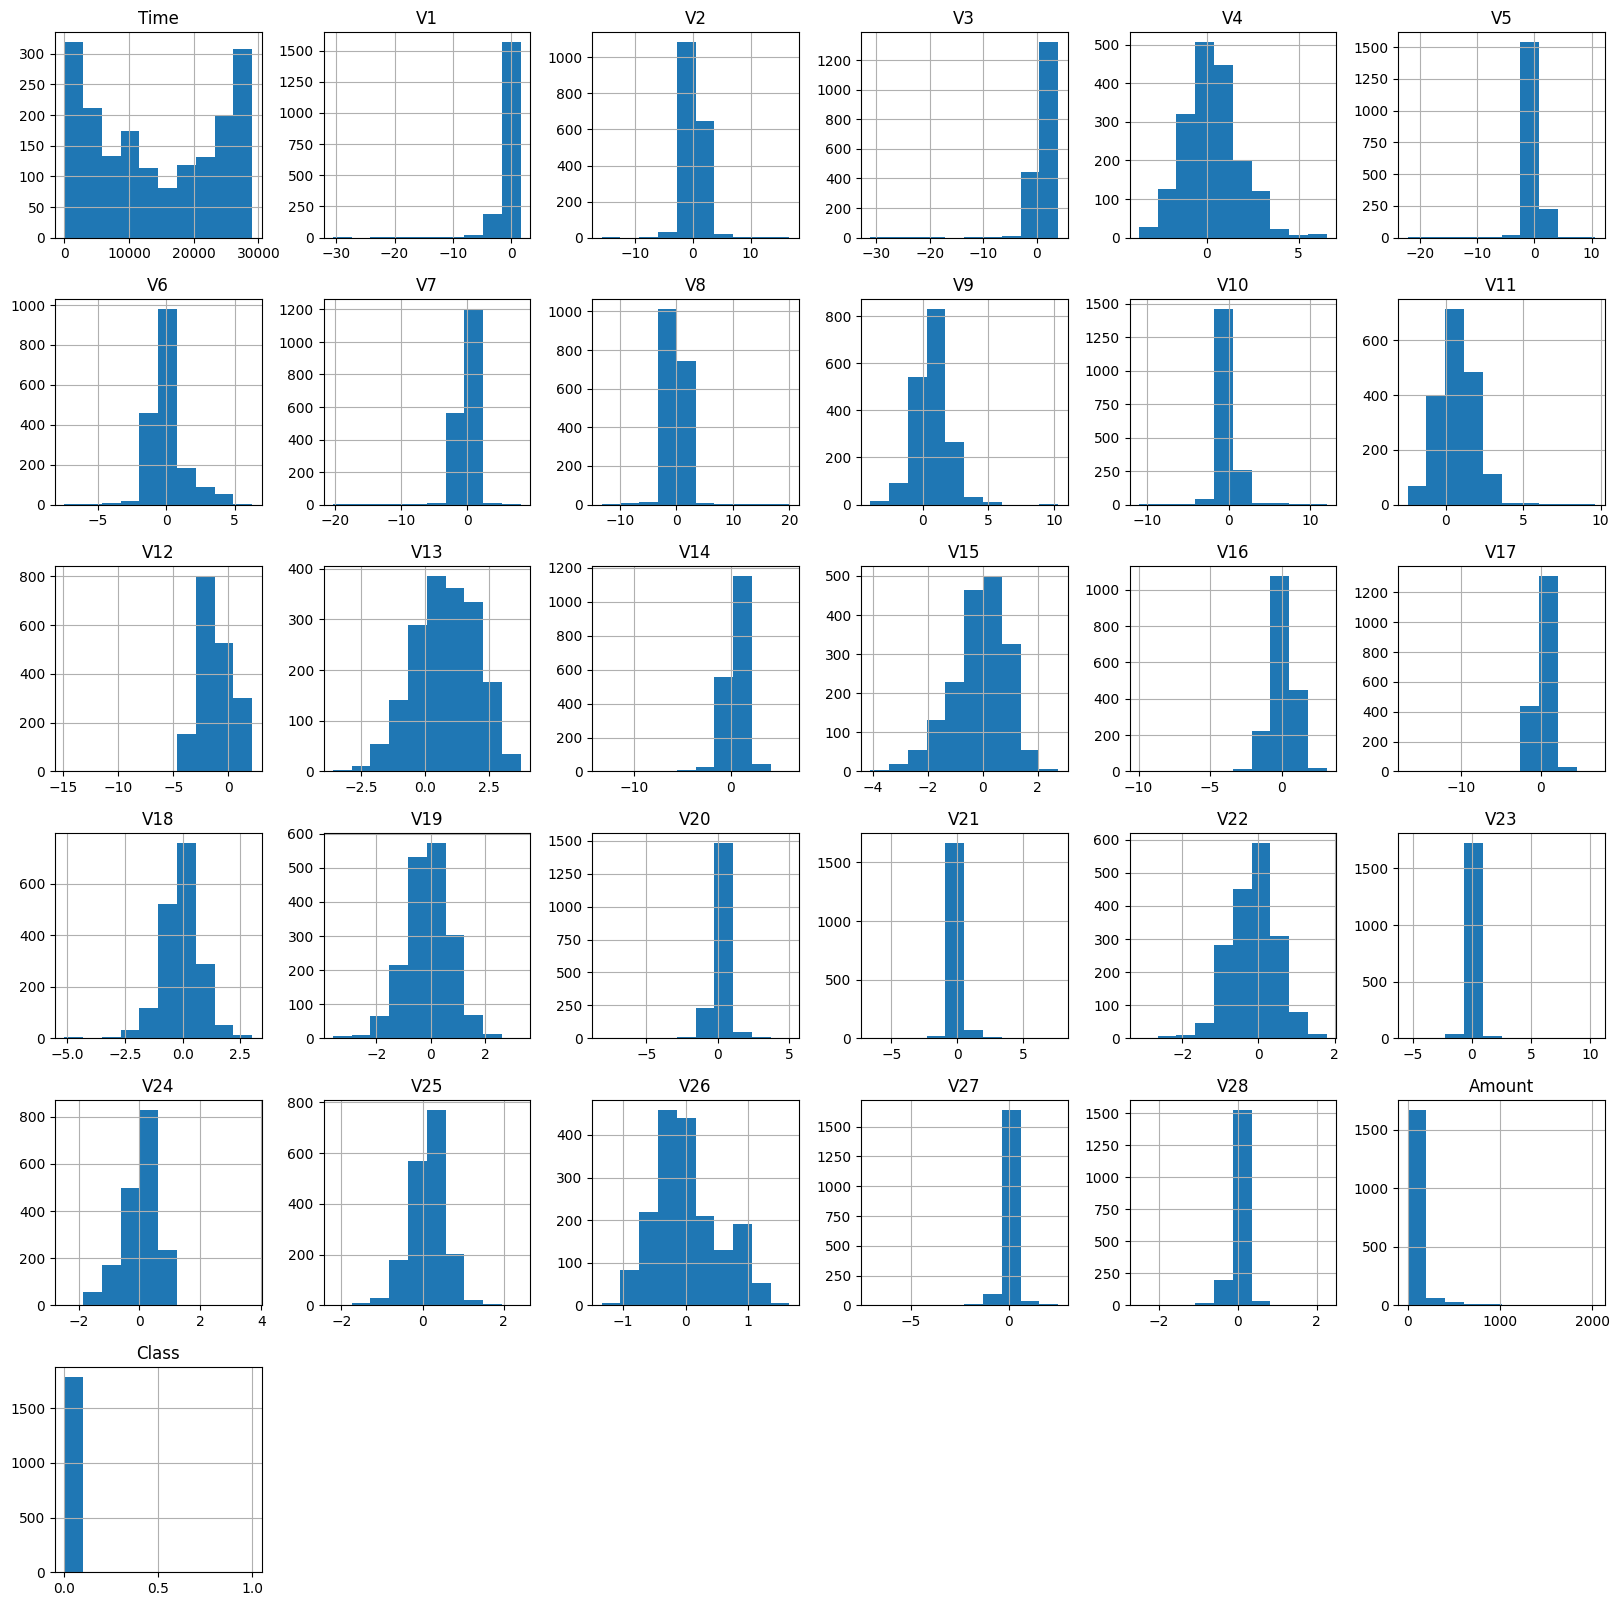

In [7]:
# Plot histograms of each parameter
data.hist(figsize = (20, 20))
plt.show()

In [8]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))



0.00392156862745098
Fraud Cases: 7
Valid Transactions: 1785


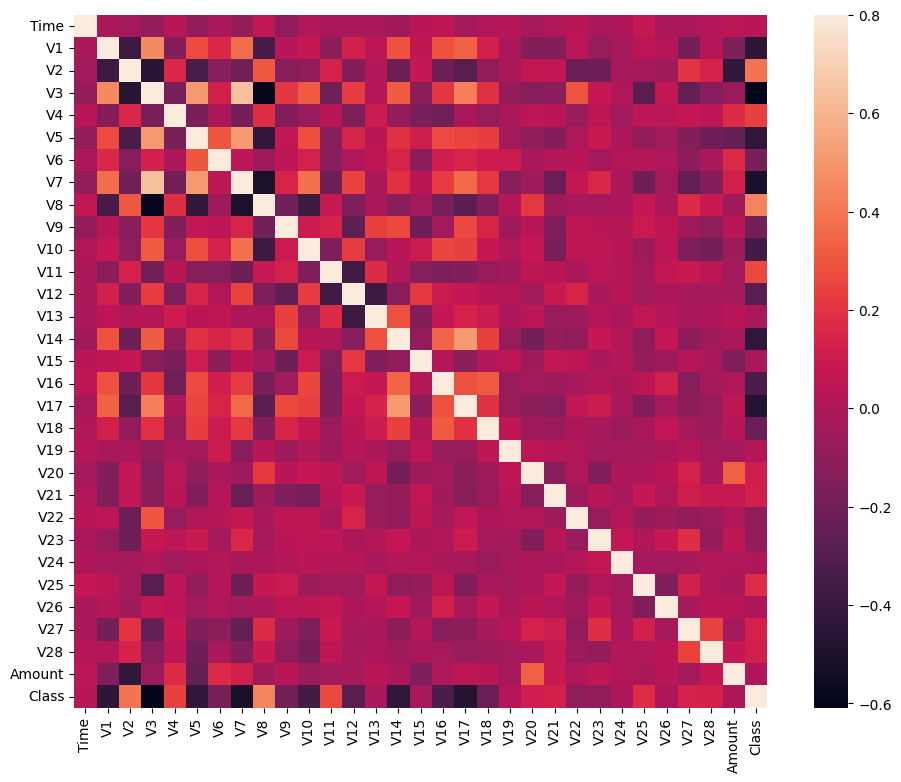

In [9]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [10]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(1792, 30)
(1792,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques:

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [12]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):

    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)

    # Reshape the prediction values to 0 for valid, 1 for fraud.
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    n_errors = (y_pred != Y).sum()

    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 7
0.99609375
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1785
         1.0       0.50      0.57      0.53         7

    accuracy                           1.00      1792
   macro avg       0.75      0.78      0.77      1792
weighted avg       1.00      1.00      1.00      1792

Local Outlier Factor: 15
0.9916294642857143
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1785
         1.0       0.00      0.00      0.00         7

    accuracy                           0.99      1792
   macro avg       0.50      0.50      0.50      1792
weighted avg       0.99      0.99      0.99      1792



<Figure size 900x700 with 0 Axes>